# **Spark Moive Recommendation**


# Contents

- [Part 1: Spark SQL and OLAP](#part-1-spark-sql-and-olap)
- [Part2: Spark ALS based approach for training model](#Part2-Spark-ALS-based-approach-for-training-model)
- [Part 3: Model Performance](#Part-3-Model-Performance)
- [Part 4: Model Apply](#Part-4-Model-Apply)



# Set Up Environments

In [18]:
# !pip uninstall pyspark
# !pip install pyspark

Found existing installation: pyspark 3.5.3
Uninstalling pyspark-3.5.3:
  Would remove:
    /usr/local/bin/beeline
    /usr/local/bin/beeline.cmd
    /usr/local/bin/docker-image-tool.sh
    /usr/local/bin/find-spark-home
    /usr/local/bin/find-spark-home.cmd
    /usr/local/bin/find_spark_home.py
    /usr/local/bin/load-spark-env.cmd
    /usr/local/bin/load-spark-env.sh
    /usr/local/bin/pyspark
    /usr/local/bin/pyspark.cmd
    /usr/local/bin/pyspark2.cmd
    /usr/local/bin/run-example
    /usr/local/bin/run-example.cmd
    /usr/local/bin/spark-class
    /usr/local/bin/spark-class.cmd
    /usr/local/bin/spark-class2.cmd
    /usr/local/bin/spark-connect-shell
    /usr/local/bin/spark-shell
    /usr/local/bin/spark-shell.cmd
    /usr/local/bin/spark-shell2.cmd
    /usr/local/bin/spark-sql
    /usr/local/bin/spark-sql.cmd
    /usr/local/bin/spark-sql2.cmd
    /usr/local/bin/spark-submit
    /usr/local/bin/spark-submit.cmd
    /usr/local/bin/spark-submit2.cmd
    /usr/local/bin/sparkR
  

In [1]:
# Download Java Virtual Machine (JVM)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# Download Spark
!wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz
# Unzip the file
!tar xf spark-3.2.1-bin-hadoop3.2.tgz
# Set up the enviornment
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = '/content/spark-3.2.1-bin-hadoop3.2'
# Install library for finding Spark
!pip install -q findspark
# Import the libary
import findspark
# Initiate findspark
findspark.init()
# Check the location for Spark
findspark.find()
# Import SparkSession
from pyspark.sql import SparkSession
# Create a Spark Session
spark = SparkSession.builder.master("local[*]").getOrCreate()
# Check Spark Session Information
spark
# Import a Spark function from library
from pyspark.sql.functions import col

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Datasets

In [4]:
cd /content/drive/MyDrive/Project/Movie_Recommendation/data/

/content/drive/MyDrive/Project/Movie_Recommendation/data


In [5]:
ls

links.csv   ratings.csv                 spark-3.2.1-bin-hadoop3.2.tgz
movies.csv  spark-3.2.1-bin-hadoop3.2/  tags.csv


In [6]:
movies_df = spark.read.load("drive/MyDrive/Project/Movie_Recommendation/data/movies.csv", format='csv', header = True)
ratings_df = spark.read.load("drive/MyDrive/Project/Movie_Recommendation/data/ratings.csv", format='csv', header = True)
links_df = spark.read.load("drive/MyDrive/Project/Movie_Recommendation/data/links.csv", format='csv', header = True)
tags_df = spark.read.load("drive/MyDrive/Project/Movie_Recommendation/data/tags.csv", format='csv', header = True)

In [7]:
movies_df.show(5)

+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|      1|    Toy Story (1995)|Adventure|Animati...|
|      2|      Jumanji (1995)|Adventure|Childre...|
|      3|Grumpier Old Men ...|      Comedy|Romance|
|      4|Waiting to Exhale...|Comedy|Drama|Romance|
|      5|Father of the Bri...|              Comedy|
+-------+--------------------+--------------------+
only showing top 5 rows



In [8]:
ratings_df.show(5)

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
+------+-------+------+---------+
only showing top 5 rows



In [9]:
links_df.show(5)

+-------+-------+------+
|movieId| imdbId|tmdbId|
+-------+-------+------+
|      1|0114709|   862|
|      2|0113497|  8844|
|      3|0113228| 15602|
|      4|0114885| 31357|
|      5|0113041| 11862|
+-------+-------+------+
only showing top 5 rows



In [10]:
tags_df.show(5)

+------+-------+---------------+----------+
|userId|movieId|            tag| timestamp|
+------+-------+---------------+----------+
|     2|  60756|          funny|1445714994|
|     2|  60756|Highly quotable|1445714996|
|     2|  60756|   will ferrell|1445714992|
|     2|  89774|   Boxing story|1445715207|
|     2|  89774|            MMA|1445715200|
+------+-------+---------------+----------+
only showing top 5 rows



In [11]:
tmp1 = ratings_df.groupBy("userID").count().toPandas()['count'].min()
tmp2 = ratings_df.groupBy("movieId").count().toPandas()['count'].min()
print('For the users that rated movies and the movies that were rated:')
print('Minimum number of ratings per user is {}'.format(tmp1))
print('Minimum number of ratings per movie is {}'.format(tmp2))

For the users that rated movies and the movies that were rated:
Minimum number of ratings per user is 20
Minimum number of ratings per movie is 1


In [12]:
tmp1 = sum(ratings_df.groupBy("movieId").count().toPandas()['count'] == 1)
tmp2 = ratings_df.select('movieId').distinct().count()
print('{} out of {} movies are rated by only one user'.format(tmp1, tmp2))

3446 out of 9724 movies are rated by only one user


<a name='part-1-spark-sql-and-olap'></a>
# Part 1: Spark SQL and OLAP

In [13]:
movies_df.registerTempTable("movies")
ratings_df.registerTempTable("ratings")
links_df.registerTempTable("links")
tags_df.registerTempTable("tags")

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/dataframe.py:138: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn(


###The number of Users

In [14]:
spark.sql("SELECT * FROM tags").show()

+------+-------+-----------------+----------+
|userId|movieId|              tag| timestamp|
+------+-------+-----------------+----------+
|     2|  60756|            funny|1445714994|
|     2|  60756|  Highly quotable|1445714996|
|     2|  60756|     will ferrell|1445714992|
|     2|  89774|     Boxing story|1445715207|
|     2|  89774|              MMA|1445715200|
|     2|  89774|        Tom Hardy|1445715205|
|     2| 106782|            drugs|1445715054|
|     2| 106782|Leonardo DiCaprio|1445715051|
|     2| 106782|  Martin Scorsese|1445715056|
|     7|  48516|     way too long|1169687325|
|    18|    431|        Al Pacino|1462138765|
|    18|    431|         gangster|1462138749|
|    18|    431|            mafia|1462138755|
|    18|   1221|        Al Pacino|1461699306|
|    18|   1221|            Mafia|1461699303|
|    18|   5995|        holocaust|1455735472|
|    18|   5995|       true story|1455735479|
|    18|  44665|     twist ending|1456948283|
|    18|  52604|  Anthony Hopkins|

In [15]:
spark.sql("SELECT * FROM ratings").show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
|     1|    163|   5.0|964983650|
|     1|    216|   5.0|964981208|
|     1|    223|   3.0|964980985|
|     1|    231|   5.0|964981179|
|     1|    235|   4.0|964980908|
|     1|    260|   5.0|964981680|
|     1|    296|   3.0|964982967|
|     1|    316|   3.0|964982310|
|     1|    333|   5.0|964981179|
|     1|    349|   4.0|964982563|
+------+-------+------+---------+
only showing top 20 rows



In [16]:
spark.sql("DESCRIBE ratings").show()

+---------+---------+-------+
| col_name|data_type|comment|
+---------+---------+-------+
|   userId|   string|   null|
|  movieId|   string|   null|
|   rating|   string|   null|
|timestamp|   string|   null|
+---------+---------+-------+



In [17]:
NumUser=spark.sql("Select Count(Distinct userId) as Number_of_Users from (Select Distinct userId from ratings UNION Select Distinct userId from tags)")
NumUser.show()

+---------------+
|Number_of_Users|
+---------------+
|            610|
+---------------+



### The number of Movies

In [18]:
#The number of Movies
NumMovie=spark.sql("Select Count(Distinct movieId) as Number_of_Moives from movies")
NumMovie.show()

+----------------+
|Number_of_Moives|
+----------------+
|            9742|
+----------------+



### Movies are rated by users and movies not rated before

In [19]:
# number of movies rated
Movie_rated_by_user=spark.sql("Select Count(distinct movieId) as Number_of_Rated_Moives From movies Where movieID in (Select movieId From ratings)")
Movie_rated_by_user.show()

+----------------------+
|Number_of_Rated_Moives|
+----------------------+
|                  9724|
+----------------------+



In [20]:
# movies that have not been rated before: take 50 movies as an example
unrated_list=spark.sql('SELECT * From movies where movieId NOT IN (Select movieId From ratings) LIMIT 50')

print('50 movies that have not been rated by users:')
unrated_list.show()

50 movies that have not been rated by users:
+-------+--------------------+--------------------+
|movieId|               title|              genres|
+-------+--------------------+--------------------+
|   1076|Innocents, The (1...|Drama|Horror|Thri...|
|   2939|      Niagara (1953)|      Drama|Thriller|
|   3338|For All Mankind (...|         Documentary|
|   3456|Color of Paradise...|               Drama|
|   4194|I Know Where I'm ...|   Drama|Romance|War|
|   5721|  Chosen, The (1981)|               Drama|
|   6668|Road Home, The (W...|       Drama|Romance|
|   6849|      Scrooge (1970)|Drama|Fantasy|Mus...|
|   7020|        Proof (1991)|Comedy|Drama|Romance|
|   7792|Parallax View, Th...|            Thriller|
|   8765|This Gun for Hire...|Crime|Film-Noir|T...|
|  25855|Roaring Twenties,...|Crime|Drama|Thriller|
|  26085|Mutiny on the Bou...|Adventure|Drama|R...|
|  30892|In the Realms of ...|Animation|Documen...|
|  32160|Twentieth Century...|              Comedy|
|  32371|Call North

###Movie Genres

In [21]:
genres_list=spark.sql('select genres from movies').toPandas()
genres_list

,genres
0,Adventure|Animation|Children|Comedy|Fantasy
1,Adventure|Children|Fantasy
2,Comedy|Romance
3,Comedy|Drama|Romance
4,Comedy
...,...
9737,Action|Animation|Comedy|Fantasy
9738,Animation|Comedy|Fantasy
9739,Drama
9740,Action|Animation


In [22]:
genre_list=spark.sql("Select Distinct explode(split(genres,'[|]')) as genres From movies Order by genres")
genre_list.show()

+------------------+
|            genres|
+------------------+
|(no genres listed)|
|            Action|
|         Adventure|
|         Animation|
|          Children|
|            Comedy|
|             Crime|
|       Documentary|
|             Drama|
|           Fantasy|
|         Film-Noir|
|            Horror|
|              IMAX|
|           Musical|
|           Mystery|
|           Romance|
|            Sci-Fi|
|          Thriller|
|               War|
|           Western|
+------------------+



### Number of Movie for Each Category

In [23]:
# size of each category
Num_Movie_for_each_category=spark.sql("Select genres, Count(movieId) as Number_of_Moives From(Select explode(split(genres,'[|]')) as genres, movieId From movies) Group By genres Order by Number_of_Moives DESC")
Num_Movie_for_each_category.show()

+------------------+----------------+
|            genres|Number_of_Moives|
+------------------+----------------+
|             Drama|            4361|
|            Comedy|            3756|
|          Thriller|            1894|
|            Action|            1828|
|           Romance|            1596|
|         Adventure|            1263|
|             Crime|            1199|
|            Sci-Fi|             980|
|            Horror|             978|
|           Fantasy|             779|
|          Children|             664|
|         Animation|             611|
|           Mystery|             573|
|       Documentary|             440|
|               War|             382|
|           Musical|             334|
|           Western|             167|
|              IMAX|             158|
|         Film-Noir|              87|
|(no genres listed)|              34|
+------------------+----------------+



In [24]:
# list all movie for each category
Movie_for_each_category=spark.sql("Select genres, concat_ws(',',collect_set(title)) as list_of_movies From(Select explode(split(genres,'[|]')) as genres, title From movies) Group By genres")
Movie_for_each_category.show()

+------------------+--------------------+
|            genres|      list_of_movies|
+------------------+--------------------+
|             Crime|Stealing Rembrand...|
|           Romance|Vampire in Brookl...|
|          Thriller|Element of Crime,...|
|         Adventure|Ice Age: Collisio...|
|             Drama|Airport '77 (1977...|
|               War|General, The (192...|
|       Documentary|The Barkley Marat...|
|           Fantasy|Masters of the Un...|
|           Mystery|Before and After ...|
|           Musical|U2: Rattle and Hu...|
|         Animation|Ice Age: Collisio...|
|         Film-Noir|Rififi (Du rififi...|
|(no genres listed)|T2 3-D: Battle Ac...|
|              IMAX|Harry Potter and ...|
|            Horror|Underworld: Rise ...|
|           Western|Man Who Shot Libe...|
|            Comedy|Hysteria (2011),H...|
|          Children|Ice Age: Collisio...|
|            Action|Stealing Rembrand...|
|            Sci-Fi|Push (2009),SORI:...|
+------------------+--------------

<a name='Part2-Spark-ALS-based-approach-for-training-model'></a>
# Part 2: Spark ALS Model Training


## Datasets

In [25]:
ratings_df.show()

+------+-------+------+---------+
|userId|movieId|rating|timestamp|
+------+-------+------+---------+
|     1|      1|   4.0|964982703|
|     1|      3|   4.0|964981247|
|     1|      6|   4.0|964982224|
|     1|     47|   5.0|964983815|
|     1|     50|   5.0|964982931|
|     1|     70|   3.0|964982400|
|     1|    101|   5.0|964980868|
|     1|    110|   4.0|964982176|
|     1|    151|   5.0|964984041|
|     1|    157|   5.0|964984100|
|     1|    163|   5.0|964983650|
|     1|    216|   5.0|964981208|
|     1|    223|   3.0|964980985|
|     1|    231|   5.0|964981179|
|     1|    235|   4.0|964980908|
|     1|    260|   5.0|964981680|
|     1|    296|   3.0|964982967|
|     1|    316|   3.0|964982310|
|     1|    333|   5.0|964981179|
|     1|    349|   4.0|964982563|
+------+-------+------+---------+
only showing top 20 rows



In [26]:
movie_ratings=ratings_df.drop('timestamp')

In [27]:
# Data type convert
from pyspark.sql.types import IntegerType, FloatType
movie_ratings = movie_ratings.withColumn("userId", movie_ratings["userId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("movieId", movie_ratings["movieId"].cast(IntegerType()))
movie_ratings = movie_ratings.withColumn("rating", movie_ratings["rating"].cast(FloatType()))

In [28]:
movie_ratings.show()

+------+-------+------+
|userId|movieId|rating|
+------+-------+------+
|     1|      1|   4.0|
|     1|      3|   4.0|
|     1|      6|   4.0|
|     1|     47|   5.0|
|     1|     50|   5.0|
|     1|     70|   3.0|
|     1|    101|   5.0|
|     1|    110|   4.0|
|     1|    151|   5.0|
|     1|    157|   5.0|
|     1|    163|   5.0|
|     1|    216|   5.0|
|     1|    223|   3.0|
|     1|    231|   5.0|
|     1|    235|   4.0|
|     1|    260|   5.0|
|     1|    296|   3.0|
|     1|    316|   3.0|
|     1|    333|   5.0|
|     1|    349|   4.0|
+------+-------+------+
only showing top 20 rows



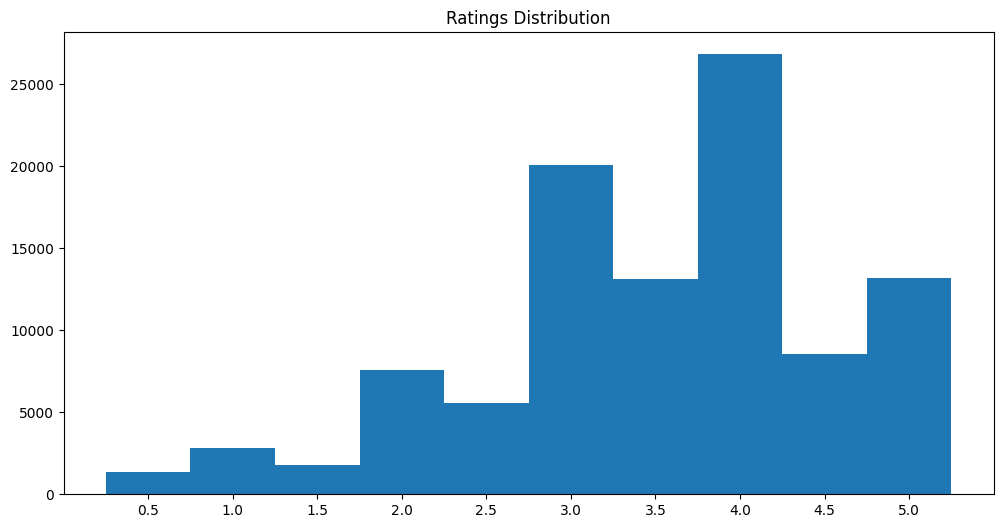

In [29]:
# bar chart of ratings
rating_count=movie_ratings.groupBy('rating').count().toPandas()
plt.figure(figsize=[12,6])
plt.bar(x='rating',height='count',data=rating_count,width=0.5)
plt.title('Ratings Distribution')
plt.xticks(np.arange(0.5,5.5,0.5))
plt.show()

The movie rating distribution shows a positive skew, with most ratings concentrated between 3.0 and 4.5, indicating that users generally rate movies favorably. The most frequent rating is around 4.0, while ratings below 2.0 are rare, suggesting fewer poorly reviewed movies or user reluctance to give low scores. A drop is noticeable from 4.5 to 5.0, implying that users reserve perfect ratings for exceptional films.

## ALS Model Selection and Evaluation


In [30]:
# Import package
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator,ParamGridBuilder

In [31]:
#Create test and train set
(training,test) = movie_ratings.randomSplit([0.8,0.2])

In [32]:
#Create ALS model
model_als = ALS(maxIter=5, rank=10, regParam=0.01, userCol="userId", itemCol="movieId", ratingCol="rating",
          coldStartStrategy="drop", seed=6)

In [33]:
#Tune model using ParamGridBuilder
params = ParamGridBuilder()\
            .addGrid(model_als.maxIter, [3, 5, 10])\
            .addGrid(model_als.regParam, [0.1, 0.01, 0.001])\
            .addGrid(model_als.rank, [5, 10, 15, 20, 25])\
            .addGrid(model_als.alpha, [0.1, 0.01, 0.001])\
            .build()

# Define evaluator as RMSE
evaluator = RegressionEvaluator(metricName="rmse", labelCol="rating",
                                predictionCol="prediction")


# Build Cross validation
cv = CrossValidator(estimator=model_als, estimatorParamMaps=params, evaluator=evaluator, numFolds=5, seed=6)


#Fit ALS model to training data
cvModel = cv.fit(training)


#Extract best model from the tuning exercise using ParamGridBuilder
bestModel=cvModel.bestModel

In [64]:
prediction_train=cvModel.transform(training)
rmse_train = evaluator.evaluate(prediction_train)
print("RMSE for training data is " + str(rmse_train))
print ("Best ALS model parameters by CV:")
print (" Rank: ", str(bestModel._java_obj.parent().getRank())),
print (" MaxIter: ", str(bestModel._java_obj.parent().getMaxIter())),
print (" RegParam: ", str(bestModel._java_obj.parent().getRegParam()))
print (" alpha: ", str(bestModel._java_obj.parent().getAlpha()))


RMSE for training data is 0.4853313797672143
Best ALS model parameters by CV:
 Rank:  25
 MaxIter:  10
 RegParam:  0.1
 alpha:  0.1


RMSE for Training Data: 0.4853
This indicates the model predicts the training data quite accurately, with an average error of 0.4861 rating points.


## Model testing


In [70]:
#Generate predictions and evaluate using RMSE
predictions=bestModel.transform(test)
rmse = evaluator.evaluate(predictions)
print ("RMSE for testing data is " +str(rmse))


RMSE for testing data is 0.8747019128614405


The RMSE value 0.8747 implies that the predicted ratings are, on average, less than 1 rating point away from the actual ratings.

In [71]:
predictions.show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   137|   1580|   3.5| 3.4387207|
|   580|   1580|   4.0| 3.4134295|
|   362|   1591|   4.0| 2.9153643|
|   593|   1580|   1.5|  3.074469|
|   108|   1959|   5.0|  3.675201|
|   368|   2366|   4.0|  2.950575|
|   115|   1645|   4.0| 2.6741889|
|   332|   2366|   3.5| 3.6934984|
|   577|   2366|   3.0| 3.4093735|
|    44|    833|   2.0|  2.966745|
|   606|   1959|   3.5|  3.565078|
|    91|   3175|   3.5| 3.4162223|
|   230|   1580|   3.5|  2.590116|
|    93|   1580|   5.0|  4.470957|
|   232|   1580|   3.5|  3.449536|
|   367|   1580|   4.0| 3.6704185|
|   599|   3997|   0.5| 1.7110245|
|   111|   4900|   4.0|  2.748333|
|   111|  44022|   3.0|  3.233304|
|    47|   1088|   4.0|  2.537293|
+------+-------+------+----------+
only showing top 20 rows



<a name='Part-3-Model-Performance'></a>
# Part 3: Model Performance

In [72]:
#Performance of all data
alldata = bestModel.transform(movie_ratings)
rmse = evaluator.evaluate(alldata)
print ("RMSE = "+str(rmse))

RMSE = 0.5820777752497887


All-data RMSE (0.5821) reflects the average error over all data set and confirms the model performs well overall.

In [40]:
alldata.registerTempTable("alldata")

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/dataframe.py:138: FutureWarning: Deprecated in 2.0, use createOrReplaceTempView instead.
  warnings.warn(


In [41]:
spark.sql("Select * From alldata").show()

+------+-------+------+----------+
|userId|movieId|rating|prediction|
+------+-------+------+----------+
|   463|   1088|   3.5|  3.231739|
|   137|   1580|   3.5| 3.4387207|
|   580|   1580|   4.0| 3.4134295|
|   580|   3175|   2.5| 3.2926047|
|   580|  44022|   3.5|  3.490157|
|   133|    471|   4.0| 3.3764033|
|   322|   1580|   3.5|  3.078237|
|   362|   1591|   4.0| 2.9153643|
|   362|   1645|   5.0| 3.9089594|
|   593|   1580|   1.5|  3.074469|
|   597|    471|   2.0|  3.663539|
|   597|   1580|   3.0| 3.5939646|
|   597|   1959|   4.0|  4.017585|
|   597|   2366|   5.0| 4.3691516|
|   108|   1959|   5.0|  3.675201|
|   155|   1580|   4.0|  3.767869|
|   155|   3175|   4.0| 3.7820804|
|    34|   1580|   2.5| 3.1628299|
|    34|   3997|   2.0| 2.0537374|
|   368|   1580|   3.0|  2.925502|
+------+-------+------+----------+
only showing top 20 rows



In [42]:
spark.sql('SELECT * '
     'FROM movies '
	   'JOIN alldata ON movies.movieId = alldata.movieId').show()

+-------+--------------------+--------------------+------+-------+------+----------+
|movieId|               title|              genres|userId|movieId|rating|prediction|
+-------+--------------------+--------------------+------+-------+------+----------+
|   1088|Dirty Dancing (1987)|Drama|Musical|Rom...|   463|   1088|   3.5|  3.231739|
|   1580|Men in Black (a.k...|Action|Comedy|Sci-Fi|   137|   1580|   3.5| 3.4387207|
|   1580|Men in Black (a.k...|Action|Comedy|Sci-Fi|   580|   1580|   4.0| 3.4134295|
|   3175| Galaxy Quest (1999)|Adventure|Comedy|...|   580|   3175|   2.5| 3.2926047|
|  44022|Ice Age 2: The Me...|Adventure|Animati...|   580|  44022|   3.5|  3.490157|
|    471|Hudsucker Proxy, ...|              Comedy|   133|    471|   4.0| 3.3764033|
|   1580|Men in Black (a.k...|Action|Comedy|Sci-Fi|   322|   1580|   3.5|  3.078237|
|   1591|        Spawn (1997)|Action|Adventure|...|   362|   1591|   4.0| 2.9153643|
|   1645|The Devil's Advoc...|Drama|Mystery|Thr...|   362|   1645

<a name='Part-4-Model-Apply'></a>

# Part 4: Model Apply

## Recommend moive to users with id: 471, 233.


In [45]:
# define a function to package the recommendation
def topKRecommend(k,id,model):
  all_recommd=model.recommendForAllUsers(k)
  user_recommd=all_recommd.where(all_recommd.userId==id).toPandas()
  if user_recommd.shape[0]==0:
    print('No user with id '+str(id)+' is found in the data.')
    return None
  user_recommd=user_recommd.iloc[0,1]
  user_recommd=pd.DataFrame(user_recommd,columns=['movieId','predicted_ratings'])
  temp=None
  for i in user_recommd['movieId']:
    if not temp:
      temp=movies_df.where(movies_df.movieId==str(i))
    else:
      temp=temp.union(movies_df.where(movies_df.movieId==str(i)))
  out=pd.concat([temp.toPandas(),user_recommd['predicted_ratings']],axis=1)
  out.index=range(1,k+1)
  return out



# top 10 for user 471
topKRecommend(10,471,bestModel)

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


,movieId,title,genres,predicted_ratings
1,177593,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama,4.795677
2,1218,"Killer, The (Die xue shuang xiong) (1989)",Action|Crime|Drama|Thriller,4.786039
3,2324,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama|Romance|War,4.733043
4,171495,Cosmos,(no genres listed),4.691722
5,78836,Enter the Void (2009),Drama,4.600130
6,3266,Man Bites Dog (C'est arrivé près de chez vous)...,Comedy|Crime|Drama|Thriller,4.591746
7,1203,12 Angry Men (1957),Drama,4.544518
8,174053,Black Mirror: White Christmas (2014),Drama|Horror|Mystery|Sci-Fi|Thriller,4.542172
9,3379,On the Beach (1959),Drama,4.509528
10,27773,Old Boy (2003),Mystery|Thriller,4.493067


In [46]:
# top 15 for user 233
topKRecommend(15,233,bestModel)

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


,movieId,title,genres,predicted_ratings
1,177593,"Three Billboards Outside Ebbing, Missouri (2017)",Crime|Drama,4.399741
2,174053,Black Mirror: White Christmas (2014),Drama|Horror|Mystery|Sci-Fi|Thriller,4.085130
3,2324,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama|Romance|War,3.977400
4,318,"Shawshank Redemption, The (1994)",Crime|Drama,3.968546
5,89904,The Artist (2011),Comedy|Drama|Romance,3.963521
6,1172,Cinema Paradiso (Nuovo cinema Paradiso) (1989),Drama,3.942897
7,1066,Shall We Dance (1937),Comedy|Musical|Romance,3.935404
8,7361,Eternal Sunshine of the Spotless Mind (2004),Drama|Romance|Sci-Fi,3.921992
9,527,Schindler's List (1993),Drama|War,3.899815
10,720,Wallace & Gromit: The Best of Aardman Animatio...,Adventure|Animation|Comedy,3.890913


## Similar moives for moive with id: 139747, 457


In [47]:
# access the movie factor matrix
movie_factors=bestModel.itemFactors
movie_factors.printSchema()
comd=["movie_factors.selectExpr('id as movieId',"]
for i in range(bestModel.rank):
  if i<bestModel.rank-1:
    comd.append("'features["+str(i)+"] as feature"+str(i)+"',")
  else:
    comd.append("'features["+str(i)+"] as feature"+str(i)+"'")
comd.append(')')
movie_factors=eval(''.join(comd))
movie_factors.createOrReplaceTempView('movie_factors')
movie_factors.show()

/content/spark-3.2.1-bin-hadoop3.2/python/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


root
 |-- id: integer (nullable = false)
 |-- features: array (nullable = true)
 |    |-- element: float (containsNull = false)

+-------+-------------+-----------+----------+-----------+-----------+------------+----------+-----------+-----------+-------------+-----------+-----------+-------------+------------+------------+------------+------------+-----------+------------+-------------+------------+-----------+-----------+-----------+----------+
|movieId|     feature0|   feature1|  feature2|   feature3|   feature4|    feature5|  feature6|   feature7|   feature8|     feature9|  feature10|  feature11|    feature12|   feature13|   feature14|   feature15|   feature16|  feature17|   feature18|    feature19|   feature20|  feature21|  feature22|  feature23| feature24|
+-------+-------------+-----------+----------+-----------+-----------+------------+----------+-----------+-----------+-------------+-----------+-----------+-------------+------------+------------+------------+------------+-----

In [90]:
missing_movie_ids = spark.sql("""
    SELECT a.movieId
    FROM movies a
    LEFT ANTI JOIN movie_factors mf
      ON a.movieId = mf.movieId
""")
missing_movie_ids.show()

+-------+
|movieId|
+-------+
| 139747|
| 166558|
|   1990|
| 100068|
|  31435|
|  59667|
|    137|
|    451|
|   6597|
|  27255|
| 142444|
| 157775|
|  27683|
|  65037|
|   6722|
|   7987|
|  25923|
|  71902|
| 133217|
| 134158|
+-------+
only showing top 20 rows



In [48]:
# method 1: Euclidean distance based similarity
# the smaller the euclidean distance between the factors, the similar the movies
# this similarity considers the actual strength
def dist_similar(k,mid):
  '''
  k: number of similar movies to find
  mid: id of the movie to find similarities
  '''
  movie_info=spark.sql('select * from movie_factors where movieId='+str(mid)).toPandas()
  if movie_info.shape[0]<=0:
    print('No movie with id '+str(mid)+' is found in the data.')
    return None, None
  temp=['select movieId,']
  for i in range(bestModel.rank):
    val=movie_info.iloc[0,i+1]
    if val>0:
      comd='feature'+str(i)+'-'+str(val)
    else:
      comd='feature'+str(i)+'+'+str(-val)
    if i<bestModel.rank-1:
      temp.append('('+comd+')*('+comd+') as sd'+str(i)+',')
    else:
      temp.append('('+comd+')*('+comd+') as sd'+str(i))
  temp.append('from movie_factors where movieId!='+str(mid))
  ssd=spark.sql(' '.join(temp))
  ssd=ssd.selectExpr('movieId','sd0+sd1+sd2+sd2+sd4 as ssd').orderBy('ssd').limit(k).toPandas()
  out=None
  for i in ssd['movieId']:
    if not out:
      out=movies_df.where(movies_df.movieId==str(i))
    else:
      out=out.union(movies_df.where(movies_df.movieId==str(i)))
  out=out.toPandas()
  out.index=range(1,k+1)
  return out, ssd

In [49]:
# method 2: cosine similarity
# the larger the cosine value, the smaller the two feature vectors' angle, the similar the movies
# this similarity considers the direction only,
def cos_similar(k,mid):
  '''
  k: number of similar movies to find
  mid: id of the movie to find similarities
  '''
  movie_info=spark.sql('select * from movie_factors where movieId='+str(mid)).toPandas()
  if movie_info.shape[0]<=0:
    print('No movie with id '+str(mid)+' is found in the data.')
    return None, None
  norm_m=sum(movie_info.iloc[0,1:].values**2)**0.5
  temp=['select movieId,']
  norm_str=['sqrt(']
  for i in range(bestModel.rank):
    comd='feature'+str(i)+'*'+str(movie_info.iloc[0,i+1])
    temp.append(comd+' as inner'+str(i)+',')
    if i<bestModel.rank-1:
      norm_str.append('feature'+str(i)+'*feature'+str(i)+'+')
    else:
      norm_str.append('feature'+str(i)+'*feature'+str(i))
  norm_str.append(') as norm')
  temp.append(''.join(norm_str))
  temp.append(' from movie_factors where movieId!='+str(mid))
  inner=spark.sql(' '.join(temp))
  inner=inner.selectExpr('movieId',\
                         '(inner0+inner1+inner2+inner3+inner4)/norm/'+str(norm_m)+' as innerP').\
                         orderBy('innerP',ascending=False).limit(k).toPandas()
  out=None
  for i in inner['movieId']:
    if not out:
      out=movies_df.where(movies_df.movieId==str(i))
    else:
      out=out.union(movies_df.where(movies_df.movieId==str(i)))
  out=out.toPandas()
  out.index=range(1,k+1)
  return out, inner

In [93]:
# movie id 139747, method 1, top 10 similar
outM1,ssd1=dist_similar(10,139747)
outM1

No movie with id 139747 is found in the data.


In [92]:
# movie id 139747, method 2, top 10 similar
outM2,inner1=cos_similar(10,139747)
outM2

No movie with id 139747 is found in the data.


In [74]:
# movie id 457, method 1, top 10 similar
out2M1,ssd2=dist_similar(10,457)
out2M1

,movieId,title,genres
1,80489,"Town, The (2010)",Crime|Drama|Thriller
2,1923,There's Something About Mary (1998),Comedy|Romance
3,6942,Love Actually (2003),Comedy|Drama|Romance
4,1354,Breaking the Waves (1996),Drama|Mystery
5,6950,"Missing, The (2003)",Adventure|Thriller|Western
6,1644,I Know What You Did Last Summer (1997),Horror|Mystery|Thriller
7,445,Fatal Instinct (1993),Comedy
8,70708,Tetro (2009),Drama|Mystery
9,57368,Cloverfield (2008),Action|Mystery|Sci-Fi|Thriller
10,3120,"Distinguished Gentleman, The (1992)",Comedy


In [75]:
# movie id 457, method 2, top 10 similar
out2M2,inner2=cos_similar(10,457)
out2M2

,movieId,title,genres
1,2366,King Kong (1933),Action|Adventure|Fantasy|Horror
2,1225,Amadeus (1984),Drama
3,1948,Tom Jones (1963),Adventure|Comedy|Romance
4,6617,Open Range (2003),Western
5,215,Before Sunrise (1995),Drama|Romance
6,2912,"Limey, The (1999)",Crime|Drama|Thriller
7,1299,"Killing Fields, The (1984)",Drama|War
8,138210,13 Hours (2016),Drama
9,1875,Clockwatchers (1997),Comedy
10,2330,Hands on a Hard Body (1996),Comedy|Documentary
